<h2>File paths and imports<h2>

In [4]:
import sys 
sys.path.append("C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code")

from chimplib.imports import *
from chimplib.recognition_utils import *

#Path to the root of the ChimpRec database ".../Chimprec Dataset/Datasets/Face Recognition/ChimpRec"
chimprec_dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/Datasets/Face Recognition/ChimpRec"
#Path where the different models based on the triplet loss for ChimpRec are stored (typically "./Code/recognition/FaceNet/Models/ChimpRec_triplet_loss")
chimprec_models_fc_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/ChimpRec_fc"

#Path to the root of the CCR database".../Chimprec Dataset/Datasets/Face Recognition/CCR"
ccr_dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/Datasets/Face Recognition/CCR"
#Path where the different models based on the triplet loss for CCR are stored (typically "./Code/recognition/FaceNet/Models/CCR_triplet_loss")
#ccr_models_tl_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/CCR_fc"
ccr_models_fc_path = "C:/Users/julie/Documents/Unif/Test_mémoire/FCL_models_CCR3"

c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchreid\reid\metrics\rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(
c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>Utils<h2>

In [11]:
#Transformation to be applied to network input images
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layers_to_test = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]

In [12]:
# @inputs:
# model: the trained model used for prediction
# val_dataset_path: path to the validation dataset directory
# transform: set of transformations to apply to images (resize, normalize, ...) with torchvision.transforms
# class_names: list of class names (individual identities) corresponding to the label indices
# has_face_labels: boolean indicating whether face label (.txt files) are used for cropping
# @output:
# precision: float representing the classification accuracy over the entire validation set
def evaluate_model_on_val(model, val_dataset_path, transform, class_names, has_face_labels):
    correctly_classified = 0
    total_img = 0

    for indiv in os.listdir(val_dataset_path):
        indiv_path = os.path.join(val_dataset_path, indiv, "images") if has_face_labels else os.path.join(val_dataset_path, indiv)
        
        for img_name in os.listdir(indiv_path):
            img_path = os.path.join(indiv_path, img_name)
            image = Image.open(img_path).convert("RGB")
            total_img += 1

            if has_face_labels:
                label_name = img_name.replace(".png", ".txt").replace(".jpg", ".txt").replace(".JPG", ".txt")
                label_path = os.path.join(val_dataset_path, indiv, "labels", label_name)
                bbox = read_yolo_label(label_path, image.width, image.height)
                image = image.crop(bbox)

            predicted_label, _ = predict_face_with_fc(image, model, transform, device)
            predicted_identity = class_names[predicted_label]
            if predicted_identity == indiv:
                correctly_classified += 1

    return correctly_classified / total_img

In [13]:
# @inputs:
# dataset_path: path to the root dataset directory
# model_folder: path to the directory containing the saved models
# has_face_labels: boolean indicating whether face labels (.txt files) are used for cropping
# @output:
# results: dictionary {layer: {k: precision}} containing the accuracy for each model configuration (k value and number of fine-tuned layer)
def run_experiment(dataset_path, model_folder, has_face_labels):
    val_path = os.path.join(dataset_path, "val")
    num_classes = len(os.listdir(val_path))

    results = {}
    for layer in layers_to_test:
        model_path = os.path.join(model_folder, f"facenet_{layer}_layers_fc.pth")
        model = CustomFCLFaceNet(num_classes=num_classes).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        train_dataset = FullyConnectedLayerDataset(os.path.join(dataset_path, "train"), transform=transform)
        class_names = list(train_dataset.class_to_idx.keys())

        precision = evaluate_model_on_val(model, val_path, transform, class_names, has_face_labels)
        print(f"Layer {layer} - Precision: {precision}")
        results[layer] = precision

    return results

<h2>Calculating model scores<h2>

<h3>ChimpRec<h3>

In [ ]:
print(run_experiment(chimprec_dataset_path, chimprec_models_fc_path, True))

<h3>CCR<h3>

In [14]:
print(run_experiment(ccr_dataset_path, ccr_models_fc_path, False))

Layer 5 - Precision: 0.4476
Layer 6 - Precision: 0.5508
Layer 7 - Precision: 0.4716
Layer 8 - Precision: 0.6156
Layer 9 - Precision: 0.6072
Layer 10 - Precision: 0.512
Layer 11 - Precision: 0.5056
Layer 12 - Precision: 0.6152
Layer 13 - Precision: 0.6276
Layer 14 - Precision: 0.6292
Layer 15 - Precision: 0.6832
Layer 16 - Precision: 0.614
Layer 17 - Precision: 0.6016
Layer 18 - Precision: 0.6396
{5: 0.4476, 6: 0.5508, 7: 0.4716, 8: 0.6156, 9: 0.6072, 10: 0.512, 11: 0.5056, 12: 0.6152, 13: 0.6276, 14: 0.6292, 15: 0.6832, 16: 0.614, 17: 0.6016, 18: 0.6396}


<h2>Graphs<h2>

In [7]:
# @inputs:
# results: dictionary {layer: {k: precision}} generated by run_experiment
# dataset_name: name of the dataset on wich the results have been calculated
# file_save_path: path where the accuracy plot image should be saved
# @output:
# None (saves and displays a plot of accuracy for different hyperparameter configurations)
def show_graph(results, dataset_name, file_save_path):
    layers = list(results.keys())

    plt.figure(figsize=(10, 6))

    values = [results[k] for k in layers]

    plt.plot(layers, values, marker='o', color='blue', linestyle='-')
    plt.xlabel('#Fine-tuned layers')
    plt.ylabel('Accuracy')
    plt.title(f'Evolution of the accuracy on the {dataset_name} validation dataset according to the value of the hyperparameters')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(file_save_path)
    plt.show()

<h3>ChimpRec<h3>

In [ ]:
#Values obtained when calculating accuracy for all configurations with the ChimpRec model (to avoid having to rerun all the code each time)
chimprec_results = {5: 0.7973568281938326, 6: 0.73568281938326, 7: 0.8237885462555066, 8: 0.8502202643171806, 9: 0.9162995594713657, 10: 0.762114537444934, 11: 0.7797356828193832, 12: 0.9427312775330396, 13: 0.9559471365638766, 14: 0.960352422907489, 15: 0.9427312775330396, 16: 0.73568281938326, 17: 0.920704845814978, 18: 0.8986784140969163}

In [ ]:
show_graph(chimprec_results, "ChimpRec", "C:/Users/julie/Documents/Unif/Test_mémoire/fine_tuning_ChimpRec_fc.svg")

<h3>CCR<h3>

In [5]:
ccr_results = {5: 0.4476, 6: 0.5508, 7: 0.4716, 8: 0.6156, 9: 0.6072, 10: 0.512, 11: 0.5056, 12: 0.6152, 13: 0.6276, 14: 0.6292, 15: 0.6832, 16: 0.614, 17: 0.6016, 18: 0.6396}

C:\Users\julie\AppData\Local\Temp\ipykernel_24112\1220418815.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


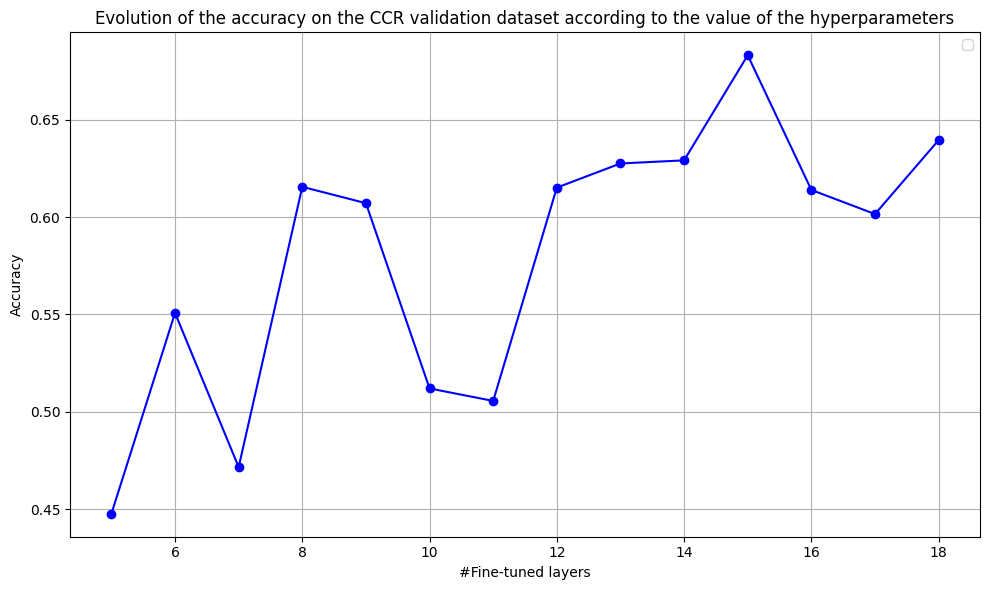

In [8]:
show_graph(ccr_results, "CCR", "C:/Users/julie/Documents/Unif/Test_mémoire/nb_layer_tuning_CCR_fc.svg")